# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [ ]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = 'data'

## Task 0: Research Question

**Research question:**
*Your chosen research question goes here*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

### A) Students Features (Inputs):

##### 1) Data Cleaning:

**Approach:**

We will begin by loading the `activity` dataset and cleaning it as follows:

- Cast columns to appropriate data types (e.g., convert to datetime formats)  
- Remove entries with missing `activity_completed` values or inconsistent timestamps (e.g., when completion occurs before the activity starts)  
- Remove entries where the activity duration exceeds 24 hours, as these likely indicate inactivity (e.g., students leaving the activity open)

In [47]:
# Load the data
activity = pd.read_csv(f'{DATA_DIR}/activity.csv')
activity_sizes = {'Original': len(activity)}

# Cast timestamps to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

# Remove entries where the activity_completed was before the activity_started
activity = activity[activity['activity_completed'] > activity['activity_started']]
activity_sizes['After removing missing or inconcistent completion'] = len(activity)

# Create a column with the duration of the activity
activity['activity_duration'] = activity['activity_completed'] - activity['activity_started']
activity['activity_duration_minutes'] = activity['activity_duration'].dt.total_seconds() / 60

# Remove entries where the activity_completed is more than 24 hours after the activity_started
activity = activity[activity['activity_duration_minutes'] <= 24 * 60]
activity_sizes['After removing duration > 24h'] = len(activity)

In addition to removing entries where the activity duration exceeds 24 hours, we will also eliminate remaining outliers using the IQR method, as it is still unlikely that a student would spend several hours on a single activity. The IQR method provides a statistically grounded threshold for identifying such outliers, removing the need to define a manual cutoff.

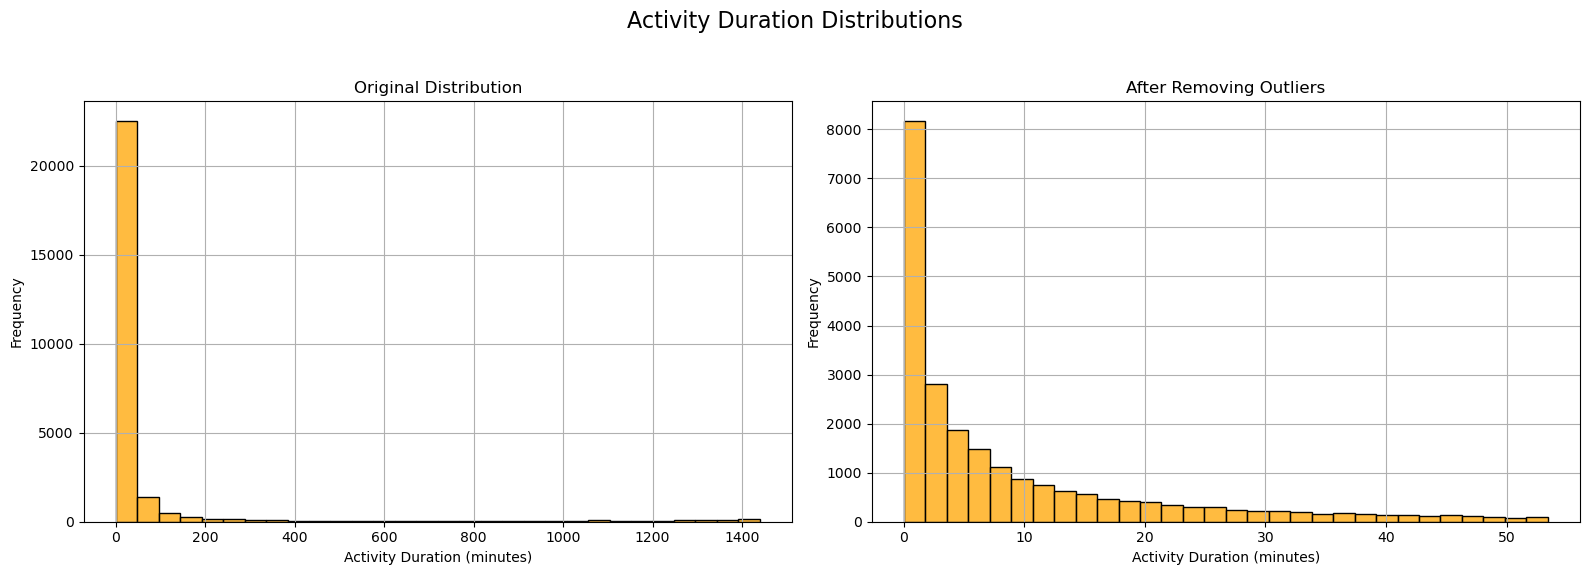

In [48]:
# Compute IQR bounds for filtering
Q1 = activity['activity_duration_minutes'].quantile(0.25)
Q3 = activity['activity_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Activity Duration Distributions", fontsize=16)

# Before filtering
sns.histplot(activity['activity_duration_minutes'], bins=30, color='orange', ax=axes[0])
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Activity Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].grid()

# Filter outliers
activity = activity[
    (activity['activity_duration_minutes'] >= lower_bound) &
    (activity['activity_duration_minutes'] <= upper_bound)
]
activity_sizes['After removing remaining outliers'] = len(activity)

# After filtering
sns.histplot(activity['activity_duration_minutes'], bins=30, color='orange', ax=axes[1])
axes[1].set_title('After Removing Outliers')
axes[1].set_xlabel('Activity Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [50]:
# Dataset evolution
print("Data set sizes at each stage:")
for stage, size in activity_sizes.items():
    print(f"- {stage}: {size} entries ({size / activity_sizes['Original'] * 100:.2f}%)")


Data set sizes at each stage:
- Original: 72897 entries (100.00%)
- After removing missing or inconcistent completion: 38881 entries (53.34%)
- After removing duration > 24h: 26217 entries (35.96%)
- After removing remaining outliers: 22754 entries (31.21%)


**Observation:**

We observe that before applying the IQR method to filter out remaining outliers, the distribution of activity duration is right-skewed, with numerous extreme values reaching up to 1,400 mins (≈ 23 hours).

After removing these outliers, the distribution remains right-skewed—likely resembling an exponential distribution, with durations ranging from 0 minutes to 1 hour.

Empirically, we found that the IQR method performs more effectively when applied after first removing entries with durations exceeding 24 hours, rather than relying on it alone.

After applying all filters, we are left with 22,754 entries—about 31% of the original dataset. The most significant reduction occurs when removing entries with missing or inconsistent completion times, which alone reduces the dataset from 100% to 53%.  

One possible solution to retain more data would be to predict the missing completion times. However, this could compromise the reliability of the analysis by introducing less representative user behavior. Therefore, we chose to leave this as a potential direction for future work, if deemed necessary.

##### 2) Features Creation:

In [7]:
user_daily_activity = activity.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

display(user_daily_activity.head())
print(f'Number of unique user entries: {user_daily_activity.user_id.nunique()}')
print(f'Number of unique (user, day) entries: {user_daily_activity.shape[0]}')


,user_id,active_day,gap_days
36137,1,2024-11-02,NaN
45192,1,2024-11-25,23.0
47334,1,2024-11-29,4.0
49725,1,2024-12-06,7.0
49736,1,2024-12-07,1.0


Number of unique user entries: 843
Number of unique (user, day) entries: 6273


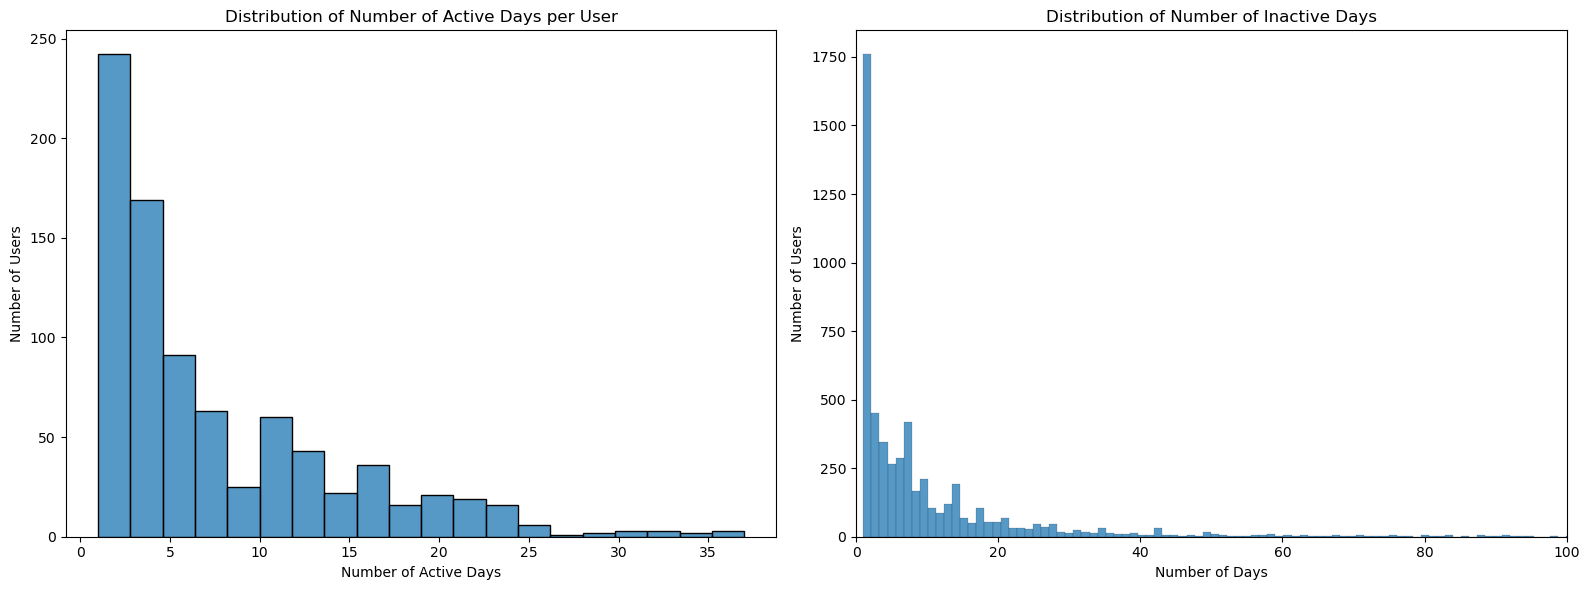

In [8]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of number of active days per user
sns.histplot(user_daily_activity['user_id'].value_counts(), bins=20, ax=axes[0])
axes[0].set_title('Distribution of Number of Active Days per User')
axes[0].set_xlabel('Number of Active Days')
axes[0].set_ylabel('Number of Users')

# Histogram of gaps between active days
sns.histplot(user_daily_activity['gap_days'], ax=axes[1])
axes[1].set_title('Distribution of Number of Inactive Days')
axes[1].set_xlabel('Number of Days')
axes[1].set_ylabel('Number of Users')
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()

user profile

In [20]:
# Compute the median of gap_days per user
user_profile_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
user_profile_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)

# Add the number of active days of that user (count)
user_profile_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

# Add the median activity duration of that user (activity_completed - activity_started) only when activity_completed is not missing
user_profile_activity['median_activity_duration'] = activity.groupby('user_id').apply(
    lambda x: (x['activity_completed'] - x['activity_started']).median() if not x['activity_completed'].isnull().all() else np.nan
).values
# Add the number of activities of that user (count)
user_profile_activity['activities_count'] = activity.groupby('user_id')['activity_id'].count().values
# Add the number of unique activity types of that user
user_profile_activity['activity_types_count'] = activity.groupby('user_id')['activity_type'].nunique().values

# Convert timedelta to minutes
user_profile_activity['median_activity_duration_minutes'] = user_profile_activity['median_activity_duration'].dt.total_seconds() / 60

/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_38955/1384183799.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_profile_activity['median_activity_duration'] = activity.groupby('user_id').apply(


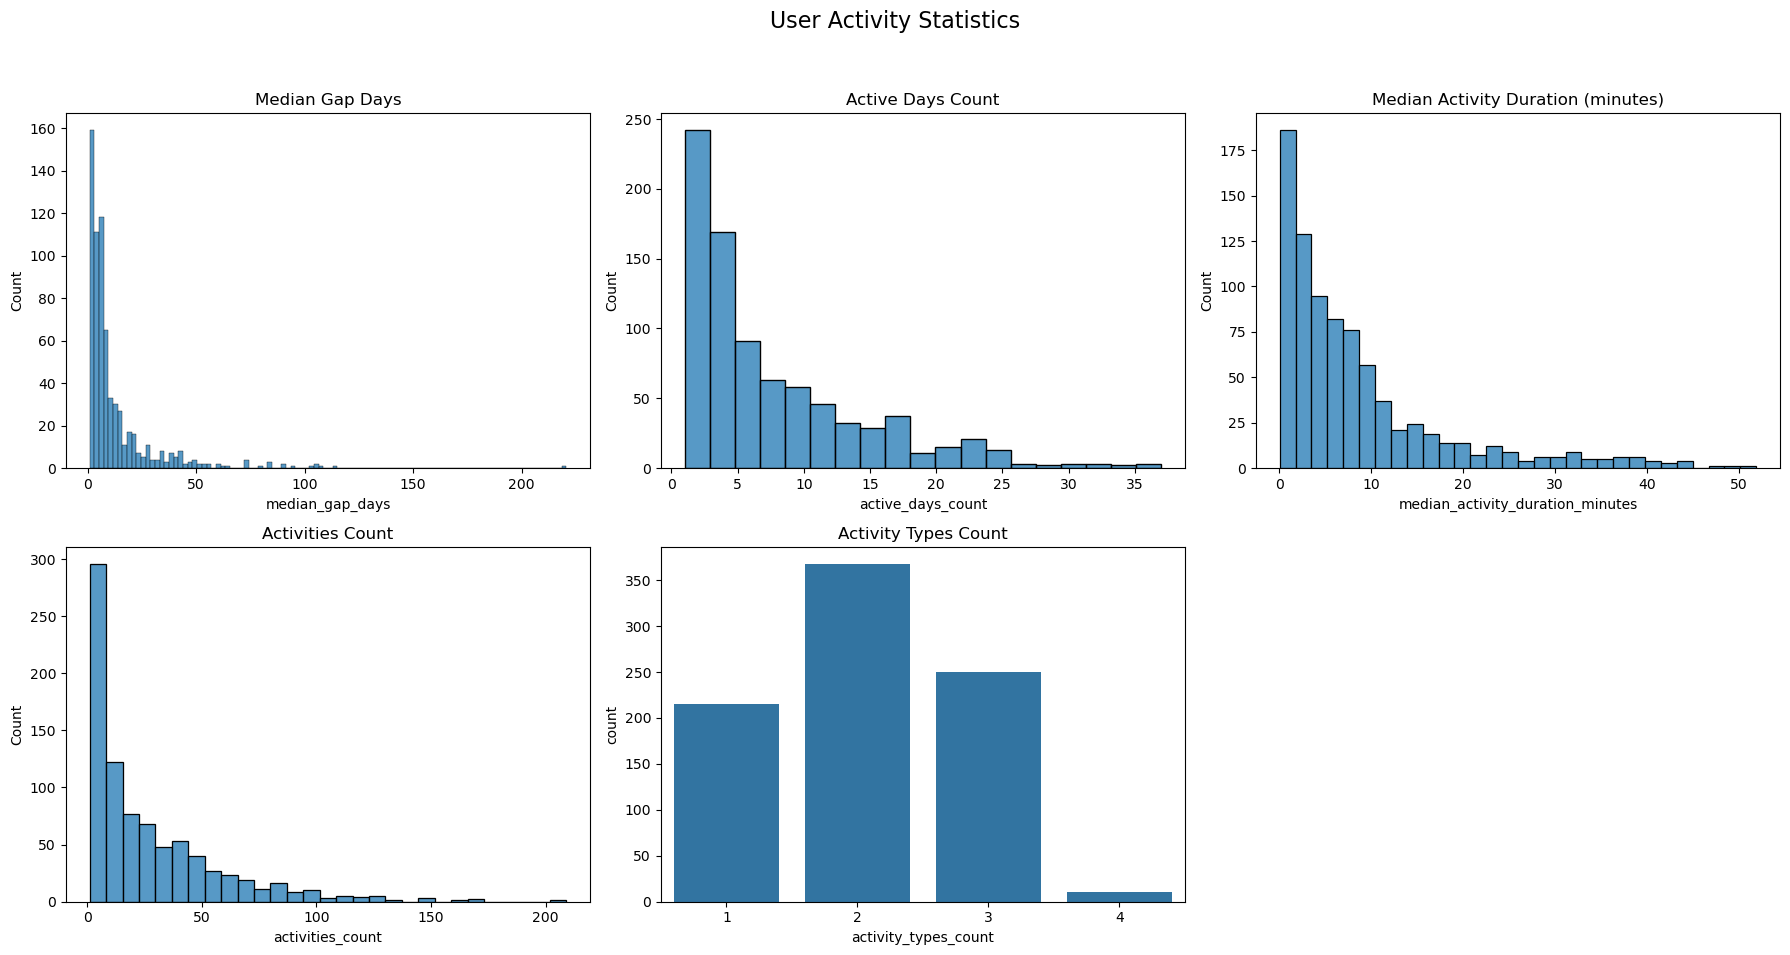

In [10]:
# Plot each column in a suitable seaborn chart using a single figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("User Activity Statistics", fontsize=16)

# Histogram for median_gap_days
sns.histplot(user_profile_activity['median_gap_days'], ax=axes[0, 0])
axes[0, 0].set_title('Median Gap Days')

# Histogram for active_days_count
sns.histplot(user_profile_activity['active_days_count'], ax=axes[0, 1])
axes[0, 1].set_title('Active Days Count')

# Boxplot for median_activity_duration
sns.histplot(user_profile_activity['median_activity_duration_minutes'], ax=axes[0, 2], bins=30)
axes[0, 2].set_title('Median Activity Duration (minutes)')

# Histogram for activities_count
sns.histplot(user_profile_activity['activities_count'], ax=axes[1, 0])
axes[1, 0].set_title('Activities Count')

# Countplot for activity_types_count
sns.countplot(x=user_profile_activity['activity_types_count'], ax=axes[1, 1])
axes[1, 1].set_title('Activity Types Count')

# Hide the last unused subplot
axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
print("- Activity per user per day:")
display(user_daily_activity.head())
print("Shape:", user_daily_activity.shape)

print("\n\n- User profile:")
display(user_profile_activity.head())
print("Shape:", user_profile_activity.shape)

- Activity per user per day:


,user_id,active_day,gap_days
36137,1,2024-11-02,NaN
45192,1,2024-11-25,23.0
47334,1,2024-11-29,4.0
49725,1,2024-12-06,7.0
49736,1,2024-12-07,1.0


Shape: (6273, 3)


- User profile:


,user_id,median_gap_days,active_days_count,median_activity_duration,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,0 days 00:04:43,19,2,4.716667
1,4,7.5,7,0 days 00:02:16,31,1,2.266667
2,6,7.0,9,0 days 00:07:39.500000,30,2,7.658333
3,7,4.0,16,0 days 00:13:35,30,2,13.583333
4,9,12.0,8,0 days 00:06:28,26,2,6.466667


Shape: (843, 7)


Scores (output)

In [12]:
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

In [13]:
# Cast timestamps to datetime
all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')

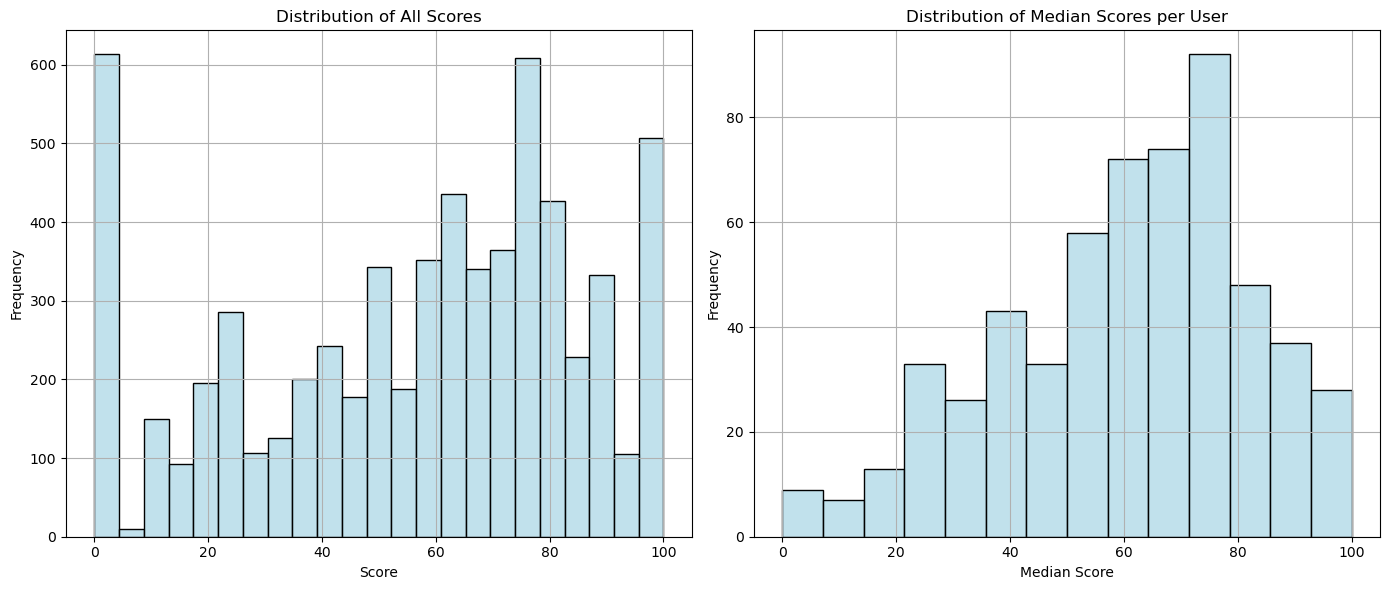

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Compute median and count of scores per user ---
median_score_per_user = all_scores.groupby('user_id')['percentage'].median().reset_index()
median_score_per_user.rename(columns={'percentage': 'median_score'}, inplace=True)
median_score_per_user['scores_count'] = all_scores.groupby('user_id')['percentage'].count().values

# --- Create side-by-side histograms with updated order and color ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Distribution of all individual scores
sns.histplot(all_scores['percentage'], color='lightblue', ax=axes[0])
axes[0].set_title('Distribution of All Scores')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Right: Distribution of median scores per user
sns.histplot(median_score_per_user['median_score'], color='lightblue', ax=axes[1])
axes[1].set_title('Distribution of Median Scores per User')
axes[1].set_xlabel('Median Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question. 

Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_38955/3277927635.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profile_activity_clean['cluster'] = kmeans.fit_predict(X_scaled)


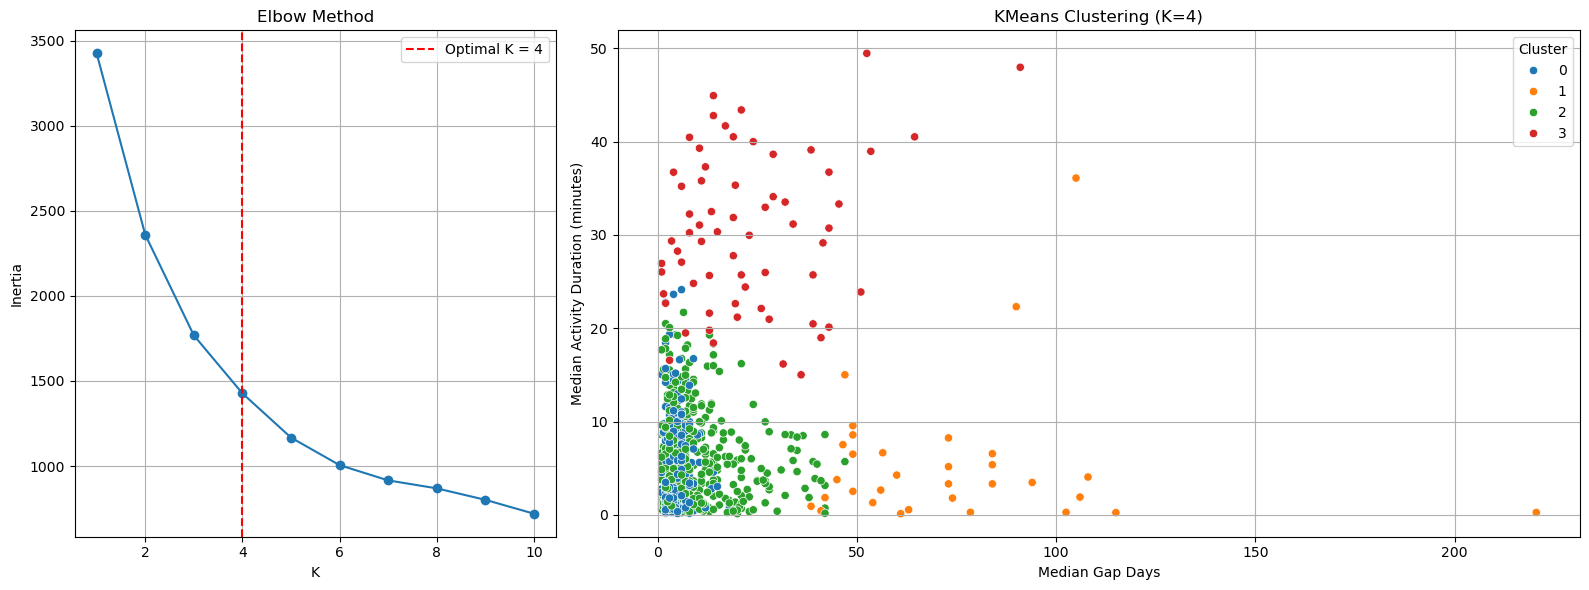

In [ ]:
# --- Hyperparameters ---
columns_used = [
    'median_gap_days',
    'active_days_count',
    'activities_count',
    'activity_types_count',
    'median_activity_duration_minutes'
]

# --- Clean data ---
user_profile_activity_clean = user_profile_activity.dropna(subset=columns_used)
X = user_profile_activity_clean[columns_used]

# --- Normalize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Elbow method to find optimal K ---
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# --- Find the "elbow" using KneeLocator ---
knee = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee.knee

# --- Apply KMeans with optimal K ---
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_profile_activity_clean['cluster'] = kmeans.fit_predict(X_scaled)

# --- Plot elbow + clusters (adjust elbow width) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})

# Elbow chart (smaller)
axes[0].plot(K_range, inertia, marker='o')
axes[0].axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].legend()
axes[0].grid(True)

# Cluster scatterplot (larger)
sns.scatterplot(
    data=user_profile_activity_clean,
    x='median_gap_days',
    y='median_activity_duration_minutes',
    hue='cluster',
    palette='tab10',
    ax=axes[1]
)
axes[1].set_title(f"KMeans Clustering (K={optimal_k})")
axes[1].set_xlabel("Median Gap Days")
axes[1].set_ylabel("Median Activity Duration (minutes)")
axes[1].legend(title='Cluster')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Define interpretation labels (ordered worst → best)
interpretation_labels = {
    'median_gap_days': [
        'uses app rarely 🔴', 'uses app occasionally 🟡', 'uses app frequently 🟢'
    ],
    'active_days_count': [
        'low activity 🔴', 'moderate activity 🟡', 'high activity 🟢'
    ],
    'activities_count': [
        'few activities 🔴', 'some activities 🟡', 'many activities 🟢'
    ],
    'activity_types_count': [
        'narrow focus', 'moderate variety', 'diverse activity'
    ],
    'median_activity_duration_minutes': [
        'short duration', 'moderate duration', 'long duration'
    ]
}

# Median values per cluster
cluster_summary = user_profile_activity_clean.groupby('cluster')[columns_used].median().T
cluster_summary.columns = [f'Cluster {c}' for c in cluster_summary.columns]

# Initialize interpretation DataFrame
interpretation_df = pd.DataFrame(index=cluster_summary.index, columns=cluster_summary.columns)

# Fill the interpretation DataFrame with 3-category emoji labels
for feature in cluster_summary.index:
    # Direction: for median_gap_days → ascending is bad, so invert the feature temporarily
    data = user_profile_activity_clean[feature]
    if feature == 'median_gap_days':
        data = -data
        values = -cluster_summary.loc[feature]
    else:
        values = cluster_summary.loc[feature]

    # Get 3 quantile bins with dropped duplicates
    _, bins = pd.qcut(data, q=3, retbins=True, duplicates='drop')
    labels = interpretation_labels[feature][:len(bins) - 1]

    for cluster in cluster_summary.columns:
        label = pd.cut([values[cluster]], bins=bins, labels=labels, include_lowest=True)[0]
        interpretation_df.loc[feature, cluster] = label

# Merge user_profile_activity_clean with user_score
user_profile_activity_score = user_profile_activity_clean.merge(
    median_score_per_user,
    on='user_id',
    how='inner'
)

# Compute average score per cluster
cluster_score = user_profile_activity_score.groupby('cluster')['median_score'].median().reset_index()
# Add the number of users in each cluster
cluster_score['users_count'] = user_profile_activity_score.groupby('cluster')['user_id'].nunique().values

cluster_score = cluster_score.T

# Rename to Cluster {c}
cluster_score.columns = [f'Cluster {c}' for c in cluster_score.columns]

# Drop row 'cluster'
cluster_score.drop(index='cluster', inplace=True)

# Concat cluster_score with the interpretation DataFrame
interpretation_score_df = pd.concat([interpretation_df, cluster_score], axis=0)
interpretation_score_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
median_gap_days,uses app frequently 🟢,uses app rarely 🔴,uses app occasionally 🟡,uses app rarely 🔴
active_days_count,high activity 🟢,low activity 🔴,moderate activity 🟡,low activity 🔴
activities_count,many activities 🟢,few activities 🔴,some activities 🟡,few activities 🔴
activity_types_count,moderate variety,narrow focus,narrow focus,narrow focus
median_activity_duration_minutes,moderate duration,moderate duration,moderate duration,long duration
median_score,61.0,65.0,65.75,71.764706
users_count,201.0,18.0,287.0,5.0


ML :

/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_38955/2393577131.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_38955/2393577131.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


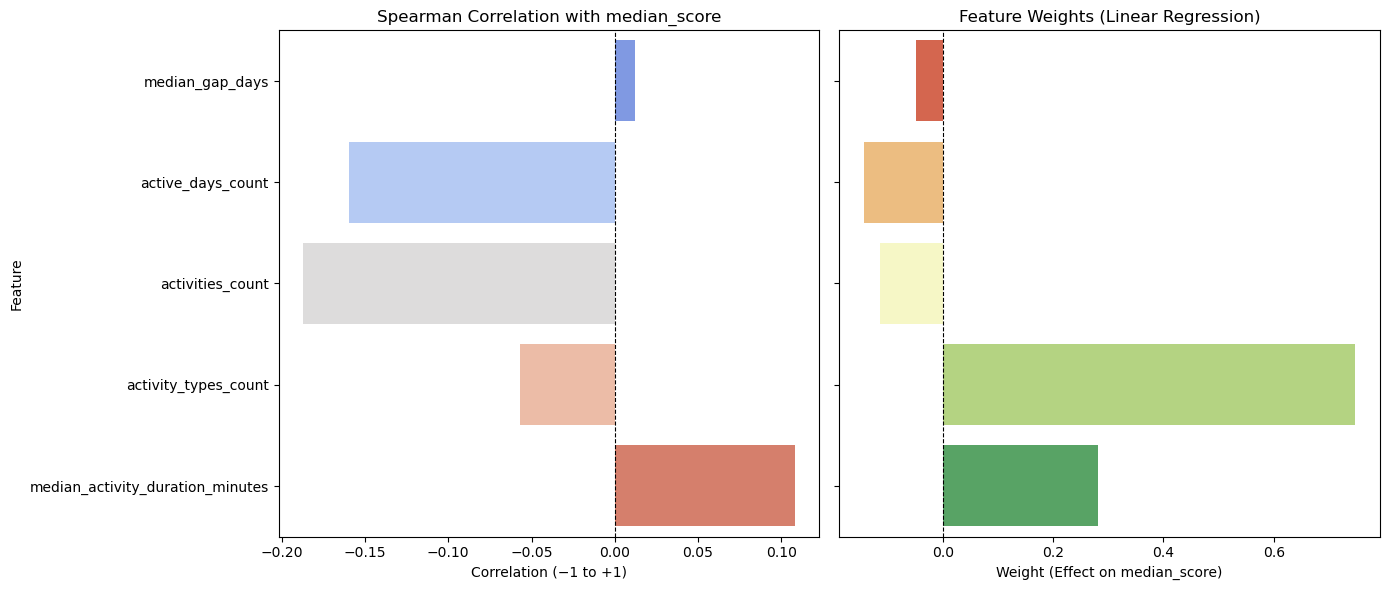

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# --- Copy and prepare data ---
df = user_profile_activity_score.copy(deep=True)
df['median_activity_duration_minutes'] = df['median_activity_duration'].dt.total_seconds() / 60


target = 'median_score'

# --- Spearman correlation ---
correlations = []
for feature in columns_used:
    corr = df[[feature, target]].corr(method='spearman').iloc[0, 1]
    correlations.append(corr)

# --- Linear regression coefficients ---
X = df[columns_used]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
weights = model.coef_

# --- Combine into a single DataFrame ---
combined_df = pd.DataFrame({
    'Feature': columns_used,
    'Spearman Correlation': correlations,
    'Linear Regression Weight': weights
})

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Spearman Correlation Plot
sns.barplot(
    data=combined_df,
    x='Spearman Correlation',
    y='Feature',
    ax=axes[0],
    palette='coolwarm'
)
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title('Spearman Correlation with median_score')
axes[0].set_xlabel('Correlation (−1 to +1)')
axes[0].set_ylabel('Feature')

# Linear Regression Weight Plot
sns.barplot(
    data=combined_df,
    x='Linear Regression Weight',
    y='Feature',
    ax=axes[1],
    palette='RdYlGn'
)
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title('Feature Weights (Linear Regression)')
axes[1].set_xlabel('Weight (Effect on median_score)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [19]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*